In [16]:
jurs = ["MI","UT"]

In [81]:
import pandas as pd
import networkx as nx
import numpy as np
import json
import os
import shutil
import re

from matplotlib.pyplot import figure

from pyvis.network import Network

#https://towardsdatascience.com/from-dataframe-to-network-graph-bbb35c8ab675

To Do:
 - pair downconnections like inverse document frequency

In [33]:
shared_fields = pd.read_csv("../data/processed/form_data.csv")
shared_fields = shared_fields[["id","jurisdiction","group","title","fields"]]
shared_fields

,id,jurisdiction,group,title,fields
0,04b3a0734774c02edf8eb9056d23954aa38e96c77c3392...,UT,3rd District Juvenile Court: Forms and Pamphlets,Community Service Worksheet Third District Juv...,"['name__1', 'name__2', '*docket_number', '*use..."
1,6e420f1b3575cfd8ef94b71977da9e38252e3395a78439...,UT,3rd District Juvenile Court: Forms and Pamphlets,Third District Juvenile Court Work Program Ref...,"['*docket_number', '*users1_birthdate', 'male'..."
2,2532cd2b6d3aaff8c47726a0abd168fb4e5cdb4977c065...,UT,3rd District Juvenile Court: Forms and Pamphlets,Utah State District Juvenile Court Probation O...,"['probation_department_court', 'special_condit..."
3,f6a6814890f21c11524d5785d772272916ff95909b7dba...,UT,Adopting a Minor Stepchild,Adoptee's Consent to Adoption and Waiver of Ri...,"['*users1_name', '*users1_address_line_one', '..."
4,be656a9a361db7c3532026b0bae372e704beb160fce37e...,UT,Adopting a Minor Stepchild,Adoption Agreement,"['*users1_name', '*users1_address_line_one', '..."
...,...,...,...,...,...
1523,31f0385280ba8218dbace7693ea04977c1cfa3278ec4f8...,MI,civil infraction,Claim of Appeal of Right/Request to Withdraw A...,"['disno', '*docket_number', 'judge', '*users1_..."
1524,2a0847b00aa3dcf37dff8c1b2c3d4dcb3247445678cda1...,MI,civil infraction,"Default Judgment, Civil Infraction",NaN
1525,07e5f95f3f4042ecd5b58fcf8a141e8931ab84124a6c19...,MI,civil infraction,"Judgment, Civil Infraction","['state_district_county', 'state', 'township',..."
1526,15f70625faa5b1a09b1839d4003d806921983fea9a8b65...,MI,civil infraction,Motion to Set Aside Default Judgment and Order...,"['disno', '*docket_number', 'judge', '*users1_..."


In [ ]:
df_slice = pd.DataFrame()
similar_df = pd.DataFrame([],columns=["id_1","id_2","title_2","similarity"])

for j in jurs:
    print(j)
    df_slice = shared_fields[shared_fields["jurisdiction"]==j]#.sample(n=100)

    for index,row in df_slice.iterrows():
        if pd.notnull(row["fields"]) and row["fields"]!="[]":
            field_list_this_form = eval(row["fields"])
            #print("\n\n")
            #print(field_list)

            for index_2,row_2 in df_slice.iterrows():
                if pd.notnull(row_2["fields"]) and row_2["fields"]!="[]" and row["id"]!=row_2["id"]:
                    field_list_that_form = eval(row_2["fields"])

                    n_fields = len(list(set(field_list_this_form+field_list_that_form)))
                    shared_feilds = len(field_list_this_form+field_list_that_form) - len(list(set(field_list_this_form+field_list_that_form)))
                    p_similar = shared_feilds/n_fields

                    #print(row["title"],row_2["title"],p_similar)

                    similar_df = similar_df.append(pd.DataFrame([[row["id"],row_2["id"],row_2["title"],p_similar]],columns=["id_1","id_2","title_2","similarity"]), ignore_index=True,sort=False)
                
similar_df

In [28]:
similar_df.to_csv("../data/processed/form_sim_data.csv", index=False, encoding="utf-8")    

In [24]:
#os.system('cp ../data/processed/form_sim_data.csv docs/forms/form_sim_data.csv')

0

# Build graphs

In [78]:
def removeSpecial(text):
    text = re.sub('[^a-zA-Z0-9]',"_",text)
    return re.sub('_+',"_",text)

Edge cases
- if group has only one form it doesn't produce a graph
- forms with the same name show up as one form here

In [82]:
for jur in shared_fields["jurisdiction"].unique():
    print("======================")
    print("\t",jur)
    print("======================")
    
    if not os.path.exists("docs/sim/%s/graphs"%(jur)):
        os.makedirs("docs/sim/%s/graphs"%(jur))
    else:
        shutil.rmtree("docs/sim/%s/graphs"%(jur))
        os.makedirs("docs/sim/%s/graphs"%(jur))
    
    for topic in shared_fields[shared_fields["jurisdiction"]==jur]["group"].unique():
        print(topic)
        df_slice = shared_fields[(shared_fields["jurisdiction"]==jur) & (shared_fields["group"]==topic)]#[:10]

        network_df = pd.DataFrame([],columns=["form_1","link","form_2"])
        for index,row in df_slice.iterrows():
            if pd.notnull(row["fields"]) and row["fields"]!="[]":
                field_list = eval(row["fields"])
                #print("\n\n")
                #print(field_list)

                for f in field_list:
                    tmp_df = df_slice.copy()
                    tmp_df["match"] = tmp_df["fields"].str.contains("'%s'"%f)
                    tmp_df = tmp_df[tmp_df["match"]==True]
                    for index_2,row_2 in tmp_df.iterrows():
                        #print(f,row["title"],"<-->",row_2["title"])
                        if row["id"]!=row_2["id"]:
                            network_df = network_df.append(pd.DataFrame([[row["title"],f,row_2["title"]]],columns=["form_1","link","form_2"]), ignore_index=True,sort=False)

        network_df

        G = nx.Graph()
        G = nx.from_pandas_edgelist(network_df, 'form_1', 'form_2')

        net = Network(notebook=True,width="100%",height="600px")
        net.from_nx(G)
        if 1 == 1:
            net.set_options("""var options = {
              "nodes": {
                "font": {
                  "strokeWidth": 6
                }
              },
               "layout": {
                "hierarchical": {
                  "enabled": true,
                  "levelSeparation": 30,
                  "edgeMinimization": false
                }
              },
              "interaction": {
                "navigationButtons": true
              }
            }""")
        elif 1 == 1:
            net.set_options("""var options = {
          "nodes": {
            "font": {
              "strokeWidth": 3
            },
            "size": 21
          },
          "physics": {
            "barnesHut": {
              "springLength": 205,
              "avoidOverlap": 1
            },
            "minVelocity": 0.75
          }
        }""")
        else:
            net.width = "65%"
            #net.show_buttons()
            net.show_buttons(filter_=["layout","nodes","physics"])

        net.show("docs/sim/%s/graphs/%s.html"%(jur,removeSpecial(topic)))

	 UT
3rd District Juvenile Court: Forms and Pamphlets
Adopting a Minor Stepchild
Adult adoption
Answering a complaint or petition
Answering a Request for Admissions
Appealing an Administrative Agency Decision
Appeals
Application for Temporary Restraining Order
Asking to Dismiss a Civil Case
Certified Court Reporters
Changing Lawyers
Child Protective Orders
Child Support
Child Welfare Appeals
Child Welfare Mediation Program Forms and Statutes
Civil Stalking Injunction
Co-Parenting Mediation Program Forms and Statutes
Conservatorship of a Minor
Court Visitor Program (CVP)
Custody Evaluation
Default Judgments
Divorce
Divorce Mediation Program Forms and Statutes
Domestic Relations Injunction
Emancipation
Ending a Guardianship or Conservatorship
Eviction
Expunging Adult Criminal Records
Expunging Juvenile Records
Fees and Fee Waiver
Financial Declaration
Financial Declaration for Restitution
Guardianship and Conservatorship Pre-appointment Tests
Guardianship of a Minor
Guardianship Signatur

In [73]:
df_slice = shared_fields[(shared_fields["jurisdiction"]=="UT") & (shared_fields["group"]=="Adopting a Minor Stepchild")]#[:10]

network_df = pd.DataFrame([],columns=["form_1","link","form_2"])
for index,row in df_slice.iterrows():
    if pd.notnull(row["fields"]) and row["fields"]!="[]":
        field_list = eval(row["fields"])
        #print("\n\n")
        #print(field_list)

        for f in field_list:
            tmp_df = df_slice.copy()
            tmp_df["match"] = tmp_df["fields"].str.contains("'%s'"%f)
            tmp_df = tmp_df[tmp_df["match"]==True]
            for index_2,row_2 in tmp_df.iterrows():
                #print(f,row["title"],"<-->",row_2["title"])
                if row["id"]!=row_2["id"]:
                    network_df = network_df.append(pd.DataFrame([[row["title"],f,row_2["title"]]],columns=["form_1","link","form_2"]), ignore_index=True,sort=False)

network_df

G = nx.Graph()
G = nx.from_pandas_edgelist(network_df, 'form_1', 'form_2')

net = Network(notebook=True,width="100%",height="600px")
net.from_nx(G)
if 1 == 1:
    net.set_options("""var options = {
      "nodes": {
        "font": {
          "strokeWidth": 6
        }
      },
       "layout": {
        "hierarchical": {
          "enabled": true,
          "levelSeparation": 30,
          "edgeMinimization": false
        }
      },
      "interaction": {
        "navigationButtons": true
      }
    }""")
elif 1 == 2:
    net.set_options("""var options = {
  "nodes": {
    "font": {
      "strokeWidth": 3
    },
    "size": 21
  },
  "physics": {
    "barnesHut": {
      "springLength": 205,
      "avoidOverlap": 1
    },
    "minVelocity": 0.75
  }
}""")
elif 1 == 3:
    net.set_options("""{
  "nodes": {
    "font": {
      "strokeWidth": 3
    }
  }
}""")
else:
    net.width = "65%"
    #net.show_buttons()
    net.show_buttons(filter_=["layout","nodes","physics"])

net.show("scratch.html")

In [10]:
G = nx.Graph()
G = nx.from_pandas_edgelist(network_df, 'form_1', 'form_2')

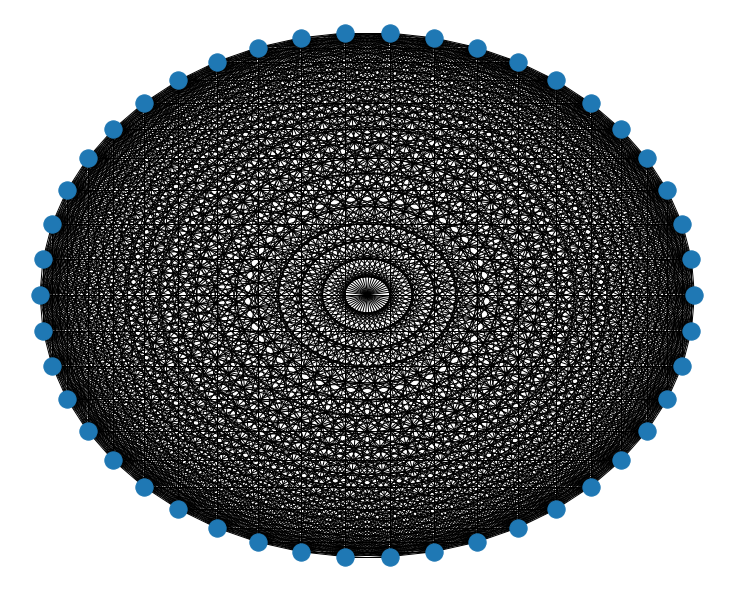

In [11]:
figure(figsize=(10, 8))
#nx.draw_shell(G) #, with_labels=True)
#nx.draw(G)
nx.draw_kamada_kawai(G)

In [12]:
leaderboard = {}
for x in G.nodes:
    leaderboard[x] = len(G[x])
    
s = pd.Series(leaderboard, name='connections')
df2 = s.to_frame().sort_values('connections', ascending=False)

In [15]:
df2[:100]

,connections
Answer to Complaint to Recover Possession of Property,46
Certificate of Legal Counsel/Waiver of Attendance,45
Petition to Discontinue Sex Offender Registration,45
"Account of Fiduciary, Long Form",45
"Commitment Order, Not Guilty by Reason of Insanity",45
Binding Arbitration Award,45
"Bond, Claim and Delivery",45
Affidavit Concerning Financial Status- Leave to Appeal Granted by Supreme Court,45
Minor's Consent to Change Name,45
Appeal of Order Denying Petition for Waiver of Parental Consent,45


In [48]:
# https://github.com/WestHealth/pyvis/pull/12

In [63]:
net = Network(notebook=True,width="100%",height="830px")
net.from_nx(G)
if 1 == 1:
    net.set_options("""var options = {
      "nodes": {
        "font": {
          "strokeWidth": 6
        }
      },
       "layout": {
        "hierarchical": {
          "enabled": true,
          "levelSeparation": 30,
          "edgeMinimization": false
        }
      },
      "interaction": {
        "navigationButtons": true
      }
    }""")
elif 1 == 1:
    net.set_options("""var options = {
  "nodes": {
    "font": {
      "strokeWidth": 3
    },
    "size": 21
  },
  "physics": {
    "barnesHut": {
      "springLength": 205,
      "avoidOverlap": 1
    },
    "minVelocity": 0.75
  }
}""")
else:
    net.width = "65%"
    #net.show_buttons()
    net.show_buttons(filter_=["layout","nodes","physics"])
    
net.show("scratch.html")

In [64]:
#net.show("docs/sim/%s/network.html"%jur)
os.system('cp scratch.html docs/sim/%s/network.html'%jur)

0